# Introduzione

Obiettivo di questo notebook: presentare il dataset `D4RL/pen/expert-v2`, esplorarne la struttura e visualizzarne il contenuto, come base per una proposta di tesi in Reinforcement Learning Offline per la robotica.

Il task "pen" richiede a una mano robotica (Adroit Hand) di manipolare una penna per portarla in una certa posizione nello spazio.

# Caricamento del dataset

In [2]:
import minari

In [3]:
dataset = minari.load_dataset("D4RL/pen/expert-v2")

In [4]:
print("Episodi totali:", dataset.total_episodes)
print("Spazio osservazioni:", dataset.observation_space)
print("Spazio azioni:", dataset.action_space)

Episodi totali: 4958
Spazio osservazioni: Box(-inf, inf, (45,), float64)
Spazio azioni: Box(-1.0, 1.0, (24,), float32)


Ogni episodio contiene:

- `observations`: vettori da 45 dimensioni (stato della mano e penna: posizioni, velocità e orientamenti)
- `actions`: vettori da 24 dimensioni (comandi ai giunti della mano)
- `rewards`: scalari per ogni passo
- `terminations`: flag booleani (successo)
- `truncations`: flag booleani (interruzione per timeout)

Questo dataset rappresenta dati raccolti da una policy esperta.

Spiegazione di ogni campo dei vettori del dataset:
https://robotics.farama.org/envs/adroit_hand/adroit_pen/

In [5]:
episode = next(dataset.iterate_episodes())
print(episode)

print(f"Osservazioni: \n{episode.observations[0]}")
print(f"Actions: \n{episode.actions[0]}")
print(f"Rewards: \n{episode.rewards[0]}")
print(f"Terminations: \n{episode.terminations[0]}")

EpisodeData(id=0, total_steps=100, observations=ndarray of shape (101, 45) and dtype float64, actions=ndarray of shape (100, 24) and dtype float32, rewards=ndarray of 100 floats, terminations=ndarray of 100 bools, truncations=ndarray of 100 bools, infos=dict with the following keys: ['success'])
Osservazioni: 
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.00000000e-01  2.50000000e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  9.99999683e-01  0.00000000e+00  7.96326711e-04
 -6.37983189e-01 -3.55911056e-01  6.82865119e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.63

The task to be completed consists on repositioning the blue pen to match the orientation of the green target. The base of the hand is fixed. The target is also randomized to cover all configurations. The task will be considered successful when the orientations match within tolerance

# Visualizzazione di un episodio

## Apertura simulatore MuJoCo

In [20]:
env = dataset.recover_environment(render_mode="human", camera_id=4)

episode = next(dataset.iterate_episodes())

env.reset()

random_actions = True

if random_actions:
    # random actions
    for _ in range(500):
        _, _, terminated, truncated, _ = env.step(dataset.action_space.sample())
else:
    # action of the episode 
    for action in episode.actions:
        _, _, terminated, truncated, i = env.step(action)
        if terminated or truncated:
            print("Terminated" if terminated else "Truncated")
            break

env.close()

## Salvataggio gif

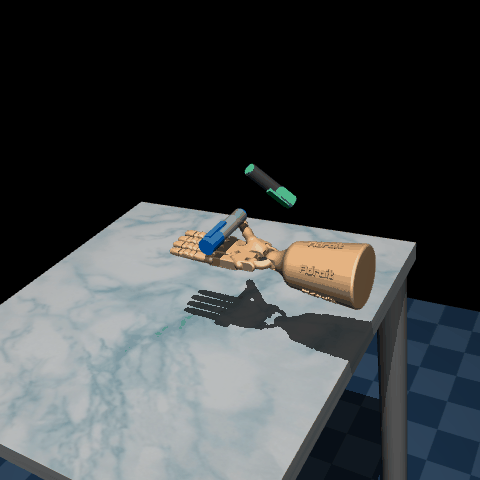

In [18]:
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image

env = dataset.recover_environment(render_mode="rgb_array", camera_id=2)

episode = next(dataset.iterate_episodes())

frames = []
env.reset()

random_actions = True

if random_actions:
    # random actions
    for _ in range(500):
        _, _, terminated, truncated, _ = env.step(dataset.action_space.sample())
        frames.append(env.render())
else:
    # action of the episode 
    for action in episode.actions:
        _, _, terminated, truncated, i = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            print("Terminated" if terminated else "Truncated")
            break

env.close()

imageio.mimsave("pen_demo.gif", frames, duration=1/30)
Image(filename="pen_demo.gif")

# Offline reinforcement learning 
L’agente impara una policy esclusivamente da dati già raccolti, senza mai interagire direttamente con l’ambiente durante il training.

Algoritmi di Offline RL:
- Behavior Cloning
- Implicit Q-Learning
- Conservative Q-Learning
- TD3+BC

# Paper originale
https://arxiv.org/pdf/1709.10087

# Mano robotica reale
https://www.shadowrobot.com/dexterous-hand-series/

## Introduzione a Minari
**Minari** è una libreria sviluppata dalla Farama Foundation che fornisce un'interfaccia standardizzata per l'utilizzo e la creazione di dataset nel contesto dell'Apprendimento per Rinforzo (RL). 

# Introduzione a D4RL

**D4RL** (Datasets for Deep Data-Driven Reinforcement Learning) è un benchmark standard per il Reinforcement Learning Offline, sviluppato per fornire **dataset realistici e strutturati** su cui valutare algoritmi RL senza necessità di interazione diretta con l’ambiente.

Sito ufficiale: [https://github.com/Farama-Foundation/d4rl](https://github.com/Farama-Foundation/d4rl)

L’obiettivo di D4RL è fornire dataset offline di alta qualità in ambienti noti (MuJoCo, Adroit, AntMaze, ecc.) per confrontare in modo consistente le performance degli algoritmi di RL offline.

## Tipologie di dataset

D4RL include una vasta gamma di ambienti:

| Categoria       | Esempi                            |
|----------------|------------------------------------|
| Classic control | CartPole, Hopper, Walker          |
| Manipolazione   | `pen`, `door`, `relocate`|
| Navigazione     | `maze2d`, `antmaze`               |
| Robotica realistica | `kitchen`        |

Ogni dataset ha varianti:
- `random`, `medium`, `expert`, `human`, `mixed`, ecc.
- In base al livello di qualità delle dimostrazioni

Esempio: `D4RL/pen/expert-v2` contiene traiettorie di un esperto che manipola una penna.

## Integrazione con Minari

Grazie alla collaborazione con la **Farama Foundation**, tutti i dataset di D4RL sono stati integrati in **Minari**, con un'interfaccia più moderna e gestibile.

# Test

In [7]:
import minari
import numpy as np
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import IQLConfig

In [8]:
dataset = minari.load_dataset("D4RL/pen/expert-v2")

In [9]:
observations = []
actions = []
rewards = []
terminals = []

for episode in dataset.iterate_episodes():
    obs = episode.observations[:-1]
    next_obs = episode.observations[1:]
    actions_ep = episode.actions
    rewards_ep = episode.rewards
    dones = np.array(episode.terminations) | np.array(episode.truncations)

    observations.append(obs)
    actions.append(actions_ep)
    rewards.append(rewards_ep)
    terminals.append(dones)

observations = np.concatenate(observations)
actions = np.concatenate(actions)
rewards = np.concatenate(rewards)
terminals = np.concatenate(terminals)

d3_dataset = MDPDataset(observations, actions, rewards, terminals)

2025-04-03 15:31.27 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float32')], shape=[(24,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(45,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2025-04-03 15:31.27 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2025-04-03 15:31.27 [info     ] Action size has been automatically determined. action_size=24


In [10]:
iql = IQLConfig().create(device="cpu")

In [11]:
iql.build_with_dataset(d3_dataset)

In [12]:
from d3rlpy.metrics import EnvironmentEvaluator

iql.fit(
    dataset=d3_dataset,
    n_steps=10000,
    n_steps_per_epoch=1000,
    evaluators={"env": EnvironmentEvaluator(env)},
)

2025-04-03 15:31.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(45,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(24,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=24)
2025-04-03 15:31.39 [warning  ] Skip building models since they're already built.
2025-04-03 15:31.39 [info     ] Directory is created at d3rlpy_logs/IQL_20250403153139
2025-04-03 15:31.39 [info     ] Parameters                     params={'observation_shape': [45], 'action_size': 24, 'config': {'type': 'iql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'actor_learning_rate': 0.0003, 'critic_learning_rate': 0.0003, 'actor_optim_factory': {'type': 'adam', 'params

Epoch 1/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-03 15:31.47 [info     ] IQL_20250403153139: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001650306463241577, 'time_algorithm_update': 0.0051957259178161625, 'critic_loss': 813.7583338012695, 'q_loss': 808.4766950073242, 'v_loss': 5.281639587235797, 'actor_loss': 71.00041978502273, 'time_step': 0.006887245655059815, 'env': 1599.6780939139105} step=1000
2025-04-03 15:31.47 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250403153139/model_1000.d3


Epoch 2/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-03 15:31.54 [info     ] IQL_20250403153139: epoch=2 step=2000 epoch=2 metrics={'time_sample_batch': 0.0015515892505645753, 'time_algorithm_update': 0.005100290536880494, 'critic_loss': 2021.861322052002, 'q_loss': 2008.236365234375, 'v_loss': 13.624959938049317, 'actor_loss': 67.79800972175597, 'time_step': 0.006690199375152588, 'env': 3201.2012299050903} step=2000
2025-04-03 15:31.54 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250403153139/model_2000.d3


Epoch 3/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-03 15:32.01 [info     ] IQL_20250403153139: epoch=3 step=3000 epoch=3 metrics={'time_sample_batch': 0.0015354669094085694, 'time_algorithm_update': 0.004852352142333985, 'critic_loss': 5163.788626342774, 'q_loss': 5140.236681335449, 'v_loss': 23.551954495429992, 'actor_loss': 50.95660427641869, 'time_step': 0.006426276206970215, 'env': 2958.528852987023} step=3000
2025-04-03 15:32.01 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250403153139/model_3000.d3


Epoch 4/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-03 15:32.07 [info     ] IQL_20250403153139: epoch=4 step=4000 epoch=4 metrics={'time_sample_batch': 0.0015054705142974853, 'time_algorithm_update': 0.004579669713973999, 'critic_loss': 9575.173326049804, 'q_loss': 9536.990572265626, 'v_loss': 38.182754055023196, 'actor_loss': 42.582387102365495, 'time_step': 0.006121060609817505, 'env': 3233.2168424194697} step=4000
2025-04-03 15:32.07 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250403153139/model_4000.d3


Epoch 5/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-03 15:32.14 [info     ] IQL_20250403153139: epoch=5 step=5000 epoch=5 metrics={'time_sample_batch': 0.0015049355030059815, 'time_algorithm_update': 0.004557316303253174, 'critic_loss': 15141.429131591796, 'q_loss': 15085.69826824951, 'v_loss': 55.730861278533936, 'actor_loss': 40.488436106204986, 'time_step': 0.006097556829452515, 'env': 2960.830638841679} step=5000
2025-04-03 15:32.14 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250403153139/model_5000.d3


Epoch 6/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-03 15:32.21 [info     ] IQL_20250403153139: epoch=6 step=6000 epoch=6 metrics={'time_sample_batch': 0.0015081441402435302, 'time_algorithm_update': 0.004573331594467163, 'critic_loss': 20855.6125201416, 'q_loss': 20784.629254882813, 'v_loss': 70.98329281997681, 'actor_loss': 35.47393298900128, 'time_step': 0.0061173043251037595, 'env': 2527.311395380615} step=6000
2025-04-03 15:32.21 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250403153139/model_6000.d3


Epoch 7/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-03 15:32.27 [info     ] IQL_20250403153139: epoch=7 step=7000 epoch=7 metrics={'time_sample_batch': 0.001505945920944214, 'time_algorithm_update': 0.004574722528457641, 'critic_loss': 26067.898096679688, 'q_loss': 25976.459810180662, 'v_loss': 91.43828968048096, 'actor_loss': 34.63118488407135, 'time_step': 0.006116200208663941, 'env': 2630.5553529260114} step=7000
2025-04-03 15:32.27 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250403153139/model_7000.d3


Epoch 8/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-03 15:32.34 [info     ] IQL_20250403153139: epoch=8 step=8000 epoch=8 metrics={'time_sample_batch': 0.0015150606632232666, 'time_algorithm_update': 0.004880804777145386, 'critic_loss': 31479.300438964845, 'q_loss': 31367.268725463866, 'v_loss': 112.0317354812622, 'actor_loss': 35.03499031472206, 'time_step': 0.006431427001953125, 'env': 3573.1398063059837} step=8000
2025-04-03 15:32.34 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250403153139/model_8000.d3


Epoch 9/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-03 15:32.41 [info     ] IQL_20250403153139: epoch=9 step=9000 epoch=9 metrics={'time_sample_batch': 0.001526374578475952, 'time_algorithm_update': 0.0047129828929901125, 'critic_loss': 36545.35970483399, 'q_loss': 36412.35172290039, 'v_loss': 133.00797718048096, 'actor_loss': 30.93664598429203, 'time_step': 0.006276442527770996, 'env': 4246.81826020067} step=9000
2025-04-03 15:32.41 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250403153139/model_9000.d3


Epoch 10/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-03 15:32.47 [info     ] IQL_20250403153139: epoch=10 step=10000 epoch=10 metrics={'time_sample_batch': 0.0015087957382202148, 'time_algorithm_update': 0.004594895601272583, 'critic_loss': 41997.95418481445, 'q_loss': 41849.07632519531, 'v_loss': 148.87784395599365, 'actor_loss': 32.57916935074329, 'time_step': 0.006140093326568604, 'env': 3864.1672303396786} step=10000
2025-04-03 15:32.47 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20250403153139/model_10000.d3


[(1,
  {'time_sample_batch': 0.001650306463241577,
   'time_algorithm_update': 0.0051957259178161625,
   'critic_loss': 813.7583338012695,
   'q_loss': 808.4766950073242,
   'v_loss': 5.281639587235797,
   'actor_loss': 71.00041978502273,
   'time_step': 0.006887245655059815,
   'env': 1599.6780939139105}),
 (2,
  {'time_sample_batch': 0.0015515892505645753,
   'time_algorithm_update': 0.005100290536880494,
   'critic_loss': 2021.861322052002,
   'q_loss': 2008.236365234375,
   'v_loss': 13.624959938049317,
   'actor_loss': 67.79800972175597,
   'time_step': 0.006690199375152588,
   'env': 3201.2012299050903}),
 (3,
  {'time_sample_batch': 0.0015354669094085694,
   'time_algorithm_update': 0.004852352142333985,
   'critic_loss': 5163.788626342774,
   'q_loss': 5140.236681335449,
   'v_loss': 23.551954495429992,
   'actor_loss': 50.95660427641869,
   'time_step': 0.006426276206970215,
   'env': 2958.528852987023}),
 (4,
  {'time_sample_batch': 0.0015054705142974853,
   'time_algorithm_u

In [41]:
env = dataset.recover_environment()
obs, _ = env.reset()
done = False
total_reward = 0

while not done:
    action = iql.predict(obs[None])[0]
    obs, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    done = terminated or truncated

env.close()
print(f"Reward totale: {total_reward}")

NameError: name 'iql' is not defined

In [40]:
env = dataset.recover_environment(render_mode="human", camera_id=2)
obs, _ = env.reset()
done = False

while not done:
    action = iql.predict(obs[None])[0]
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()
imageio.mimsave("iql_pen.gif", frames, duration=1/30)

NameError: name 'iql' is not defined